In [1]:
import pandas as pd
import numpy as np
import gc
import sys
import os
import torch
from tqdm import tqdm

/home/user/anaconda3/envs/11785_project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss, DeepAR
from pytorch_forecasting.data.encoders import NaNLabelEncoder 

# Data

## Download Data by DYJ

In [3]:
if False:
    !gdown 1yhCV0v-GgYAfhKnJptvqSZdivvnAa27M -O /home/ubuntu/data/databyid.zip
    !unzip -q /home/ubuntu/data/databyid.zip -d /home/ubuntu/data

In [3]:
DIR_BYID = '/home/ubuntu/data/content/databyid'
DIR_BYID = '/media/user/12TB1/HanLi/GitHub/CMU11785-project/local_data/content/databyid'
ls_all_invest_ids = sorted([int(fn.split('.')[0]) for fn in os.listdir(os.path.join(DIR_BYID, 'target'))])

f_cols = [f"f_{i}" for i in range(300)]

n = 10
ls_dfs = []
for id in ls_all_invest_ids[:n]:
    df_f_id = pd.DataFrame(np.load(os.path.join(DIR_BYID, f'feats/{id}.npy')), columns=f_cols)
    df_t_id = pd.DataFrame(np.load(os.path.join(DIR_BYID, f'target/{id}.npy')), columns=['target'])
    df_f_id['investment_id'] = id
    ls_dfs.append(pd.concat([df_t_id, df_f_id], axis=1))

df = pd.concat(ls_dfs).reset_index().rename(columns={'index': 'time_id'})
df = df.sort_values(by=['time_id', 'investment_id']) # sort by time before splitting


In [4]:
df.reset_index(drop=True, inplace=True)

df.investment_id = df.investment_id.astype(str)
df.time_id = df.time_id.astype(int)
df.dtypes

time_id            int64
target           float64
f_0              float64
f_1              float64
f_2              float64
                  ...   
f_296            float64
f_297            float64
f_298            float64
f_299            float64
investment_id     object
Length: 303, dtype: object

In [5]:
df

,time_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,investment_id
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,...,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566,1
2,0,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,...,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624,2
3,0,0.000000,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,...,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624,3
4,0,0.000000,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,...,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12195,1219,0.000000,-2.249727,0.580445,-0.497117,1.009598,0.234179,-2.126438,-0.039451,-0.181319,...,0.811402,-1.168044,0.875537,0.421628,0.132988,-0.075548,-1.190996,1.102322,0.403788,5
12196,1219,0.026752,-0.594910,0.580445,0.611330,-0.459240,-0.132116,0.518428,-0.466611,-0.959206,...,-1.232434,-0.089092,0.875537,0.421628,-0.498323,-0.075548,-0.105665,-1.321038,-0.132180,6
12197,1219,0.000000,-0.594910,0.580445,0.611330,-0.459240,-0.132116,0.518428,-0.466611,-0.959206,...,-1.232434,-0.089092,0.875537,0.421628,-0.498323,-0.075548,-0.105665,-1.321038,-0.132180,7
12198,1219,-0.727649,0.514724,1.621022,-0.747425,-0.430440,-0.181709,-0.954293,-1.774378,2.272305,...,-1.232434,-0.419952,0.875537,-2.371759,-0.332430,1.363181,-0.299573,0.881399,-0.540605,8


In [6]:
max_encoder_length = 12
max_prediction_length = 1
training_cutoff = 1000

In [7]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_id <= training_cutoff],
    time_idx='time_id',  # column name of time of observation
    target='target',  # column name of target to predict
    group_ids=['investment_id'],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    # covariates static for a timeseries ID
    static_categoricals=[],
    static_reals=[],
    # investment_id as categorical covariates that are known in the future for preddiction
    time_varying_known_categoricals=['investment_id'],
    # put in f_cols and time_id as real covariates that are known in the future for prediction
    time_varying_known_reals = f_cols + ['time_id'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    allow_missing_timesteps=False,
    # having add_nan=True in Encoder allows us to predict unseen investments
    categorical_encoders = {'__group_id__investment_id': NaNLabelEncoder(add_nan=True), 'investment_id': NaNLabelEncoder(add_nan=True)}
)

In [8]:
train_dataloader = training.to_dataloader(train=True, batch_size=128, num_workers=4)

In [12]:
#training.get_parameters()

In [9]:
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True,
    categorical_encoders = {'__group_id__investment_id': NaNLabelEncoder(add_nan=True), 'investment_id': NaNLabelEncoder(add_nan=True)})

In [10]:
val_dataloader = validation.to_dataloader(train=False, batch_size=32 * 10, num_workers=4)

In [15]:
training.save("training.pkl")
validation.save("validation.pkl")


Global seed set to 42
/home/user/anaconda3/envs/11785_project/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/user/anaconda3/envs/11785_project/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/user/anaconda3/envs/11785_project/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them u

Number of parameters in network: 429.3k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Finding best initial lr: 100%|██████████| 100/100 [02:05<00:00,  1.20s/it]Restoring states from the checkpoint path at /media/user/12TB1/HanLi/GitHub/CMU11785-project/src/notebooks/.lr_find_adaf3cc0-dcea-4399-9c94-54c9944e0c10.ckpt
/home/user/anaconda3/envs/11785_project/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1721: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': None}"].
  rank_zero_warn(
Finding best initial lr: 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


suggested learning rate: 1.3182567385564071e-05


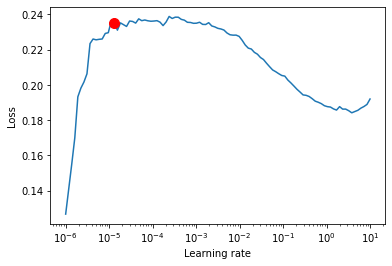

In [11]:
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft_model = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft_model.size()/1e3:.1f}k")


# find optimal learning rate
res = trainer.tuner.lr_find(
    tft_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [12]:
from pytorch_lightning.loggers import WandbLogger
#DIR_LOGS = '/content/logs' 
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

# checkpoint_callback = ModelCheckpoint(monitor='val_SMAPE', dirpath='/home/ubuntu/efs/project/', save_top_k=2, filename='500-default-{epoch:02d}-{val_SMAPE:.2f}')
checkpoint_callback = ModelCheckpoint(monitor='val_SMAPE', dirpath='/media/user/12TB1/HanLi/GitHub/CMU11785-project/', save_top_k=2, filename='500-default-{epoch:02d}-{val_SMAPE:.2f}')

# wandb_logger = WandbLogger(project="ubiquant", log_model=True)

wb_logger = WandbLogger(
    entity="11785_project",
    project="PyTorchForecasting_test",
    name='Test_421',
    log_model=True
)

trainer = pl.Trainer(
    max_epochs=5,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
#    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=wb_logger,
)
# fit network
trainer.fit(
    tft_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tsbyq_wb (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/user/anaconda3/envs/11785_project/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /media/user/12TB1/HanLi/GitHub/CMU11785-project exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 66    
3  | prescalers                         | ModuleDict                      | 4.8 K 
4

Epoch 4: 100%|██████████| 78/78 [08:29<00:00,  6.53s/it, loss=0.129, v_num=g6ai, train_loss_step=0.146, val_loss=0.167, train_loss_epoch=0.128]  
